# Monte carlo Simulation of Classical 2D Ising model.

### Hamiltonian
   We will be simulating a one-dimensional (1D) Quantum Ising chain, which is given by,
\begin{equation}
\mathcal{H} = -\sum_{i}\big[J\sigma^z_{i}\sigma^z_{i+1} + h\sigma^x_i\big] = -\sum_{i} (H^D_i + H^O_i)
\end{equation}

---------------------------

**Aim**

Mapping it to a (D+1) dimensional classical model and simulating it using classical monte carlo technique.

---------------------------

### Suzuki-Trotter decomposition

 It is an approximation and not a exact transformation scheme that is intended to map to a classical model of a quantum Hamiltonian.
 
We know, 
\begin{eqnarray}
\mathcal{Z} &=& \text{Tr} \{e^{-\beta \mathcal {H}}\} \nonumber \\
&=& \sum_{\{ \alpha \} } \langle \alpha |e^{(-\Delta T \mathcal{H})^m} | \alpha \rangle, \quad \quad \text{where, } \Delta  =\beta/m
\end{eqnarray}
For small $\Delta $ ($<<1$), the following product,
\begin{equation}
e^{-\Delta  H} \approx e^{-\Delta T H^D}e^{-\Delta T H^{O}}
\end{equation}
Therefore, 
\begin{eqnarray}
\mathcal{Z} &\approx& \sum_{\{ \alpha \} } \langle \alpha | \bigg[\prod_{i} e^{-\Delta T H^D_i}e^{-\Delta T H^O_i}\bigg]^m | \alpha \rangle, \nonumber \\
\end{eqnarray}
Can be written as,
\begin{eqnarray}
\mathcal{Z} &=& \sum_{\{ \alpha \} } e^{-\beta H^{D}(\alpha)}\langle \alpha | \bigg[\prod_{l=1}^m e^{-\Delta T H^O}\bigg]^m | \alpha \rangle, \nonumber \\
&=& \sum_{\{ \alpha_0 \}, \{ \alpha_1 \}, ..., \{ \alpha_{m-1} \}, } e^{-\beta H^{D}(\alpha)}\langle \alpha_0 | e^{-\Delta T H^O} |\alpha_{m-1}\rangle \langle\alpha_{m-1} | e^{-\Delta T H^O} |\alpha_{m-2}\rangle..... \langle \alpha_{1} e^{-\Delta T H^O} | \alpha_0 \rangle, \nonumber \\
\end{eqnarray}
where, $\langle \alpha_0 | e^{-\Delta T H^O} |\alpha_{m-1}\rangle$ takes the following values,
\begin{equation}
\langle \alpha_0 | e^{-\Delta T H^O} |\alpha_{m-1}\rangle \sim \prod_{i}^{N} \mathcal{I}\otimes\langle\uparrow |e^{-\Delta T H^O_i}|\downarrow\rangle = \prod_{i}^{N}\big[(\frac{1}{2}\sinh(2\Delta h))^{1/2}e^{\frac{1}{2} \log(\coth(\Delta h))S^{k}_iS^{k-1}_i}\big]
\end{equation}

After substituting the above expression in the previous equation and upon simplification we get,
\begin{equation}
\mathcal{Z} = \lim_{m\rightarrow \infty}C_m\sum_{\{\alpha^i \}}e^{-\beta H_{eff}}
\end{equation}
Where, 
\begin{equation}
H_{eff} = -\frac{J}{M}\sum_{i,M}\sigma_i^j\sigma_{i+1}^j - K_{eff}\sum_{i,M}\sigma_i^j\sigma_{i}^{j+1}, \quad \quad  K_{eff} = \frac{1}{2\beta}\log(\coth(\Delta h))
\end{equation}
Which is nothing but the two dimensional classical model. Therefore, the transverse field in 1D quantum Ising chain is mapped to a classical Ising interaction along the newly added dimension but with an effective interaction given as $K_{eff}$. While the Ising interaction in quantum case remained the same except for the fact that the effective coupling constant is reduced by a factor m, i.e, J/m. In order to minimize the error due to this discretization along the trotter axis (newly added dimension) it is desireful to choose a large $m$, such that $m \approx N/\beta $.  

# Problem:
   1. Plot the energy, |magnetization| versus temperature for the 1D Quantum Ising model for a system size of 96, 128.
   2. Show the variation of |magnetization| versus temperature for various values of h.   

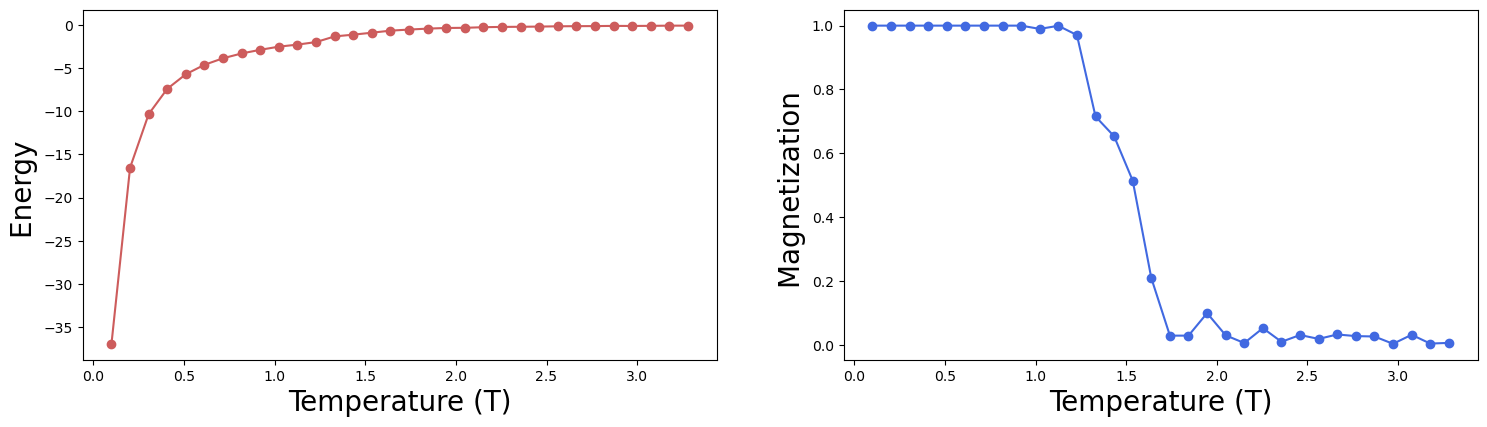

In [7]:
# Ising
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from scipy.sparse import spdiags,linalg,eye

J=1.0

def initialstate(N,L):   
    ''' 
    Generates a random spin configuration for initial condition
    '''
    state = np.ones((N,L))#2*np.random.randint(2, size=(N,N))-1
    return state



def mcmove(config, J, Kx, N, L, beta):
    '''
    Monte Carlo move using Metropolis algorithm 
    '''
    for i in range(N):
        for j in range(L):
                a = np.random.randint(0, N)
                b = np.random.randint(0, L)
                s =  config[a, b]
                nb = (J/L)*(config[(a+1)%N,b] +  config[(a-1)%N,b]) + Kx*(config[a,(b+1)%L] + config[a,(b-1)%L])
                cost = 2*s*nb
                
                if cost < 0:
                    s *= -1
                elif rand() < np.exp(-cost*beta):
                    s *= -1
                config[a, b] = s
    return config



def calcEnergy(config,N, L, Kx):
    '''
    Energy of a given configuration
    '''
    energy = 0 
    global J
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = (J/L)*(config[(i+1)%N, j] + config[i,(j+1)%N]) + Kx*(config[(i-1)%L, j] + config[i,(j-1)%L])
            energy += -nb*S
    return energy/2.  # to compensate for over-counting



def calcMag(config):
    '''
    Magnetization of a given configuration
    '''
    global J
    mag = np.sum(config)
    return mag

def main():
    nt      = 32          #  number of temperature points
    N       = 16          #  size of the lattice, N x N
    L       = 16
    eqSteps = 2**5        #  number of MC sweeps for equilibration
    mcSteps = 2**5        #  number of MC sweeps for calculation
    J = 1.0
    h = 0.1


    T       = np.linspace(0.1, 3.28, nt); 
    E,M,C,X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
    n1, n2  = 1.0/(mcSteps*N*L), 1.0/(mcSteps*mcSteps*N*L) 
    # divide by number of samples, and by system size to get intensive values

    #----------------------------------------------------------------------
    #  MAIN PART OF THE CODE
    #----------------------------------------------------------------------


    for tt in range(nt):
        config = initialstate(N,L)         # initialise

        E1 = M1 = E2 = M2 = 0
        iT=1.0/T[tt]; iT2=iT*iT;

        Kx = -(0.5* iT)*np.log(np.tanh(h/(L*iT))) 
        for i in range(eqSteps):         # equilibrate
            mcmove(config, J, Kx, N, L, iT)           # Monte Carlo moves

        for i in range(mcSteps):
            mcmove(config, J, Kx, N, L, iT)           
            Ene = calcEnergy(config,N, L, Kx)     # calculate the energy
            Mag = calcMag(config)        # calculate the magnetisation

            E1 = E1 + Ene
            M1 = M1 + Mag
            M2 = M2 + Mag*Mag 
            E2 = E2 + Ene*Ene


        # divide by number of sites and iteractions to obtain intensive values    
        E[tt] = n1*E1
        M[tt] = n1*M1
        C[tt] = (n1*E2 - n2*E1*E1)*iT2
        X[tt] = (n1*M2 - n2*M1*M1)*iT


    #----------------------------------------------------------------------
    #  plot the calculated values   
    #----------------------------------------------------------------------

    f = plt.figure(figsize=(18, 10)); #  


    sp =  f.add_subplot(2, 2, 1 );
    plt.plot(T, E, marker='o', color='IndianRed')
    plt.xlabel("Temperature (T)", fontsize=20);
    plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');


    sp =  f.add_subplot(2, 2, 2 );
    plt.plot(T, abs(M), marker='o', color='RoyalBlue')
    plt.xlabel("Temperature (T)", fontsize=20); 
    plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight'); 
    
if __name__ == "__main__":    
    main()